# Apresentação e Objetivo
A nota dos participantes ENEM é calculado pelo INEP a partir dos padrões de respostas às questões das provas, com certas suposições:

* É usado um modelo IRT do tipo 3PL 
* Os parâmetros a, b e c (discriminação, dificuldade e chute, respectivamente) do modelo são calibrados para cada item previamente, por métodos de *linking* que coloquem novas itens na escala ENEM
* A estimativa do *score* na escala ENEM usa o método EAP ("Expected a posteriori")

O que quero fazer neste notebook é fazer uma certa análise de robustez das notas do ENEM atribuídas pelo INEP. Uma motivação é mostrar que o número atribuído a cada candidato deve ser interpretado. Quero chacoalhar um pouco na suposta objetividade da nota, a ideia que a prova ENEM reflete 

Uma maneira de fazer isso é criar uma série de contrafactuais, mudanças aparente inocentes no procedimento de cálculo das notas e estudar como a nota muda. Ou seja, estou imaginando uma espécie de propagação de incerteza, na linguagem de físicos: 

$$ \text{Nota ENEM} = f(\text{padrão de respostas},\text{parâmetros IRT},...) = f(\vec{x})$$
$$ \Delta f \approx \frac{\partial f}{\partial x} \Delta x$$



In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from util import load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep, scalecalparams, enem_scale
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproduzir as notas do INEP
Antes de investigar o efeito de pequenas variações nos *inputs* e metodologia do cálculo, precisamos ter certeza que conseguimos reproduzir as notas que o INEP calcula. Há uma função `score_inep` em `util.py` que calcula 

In [2]:
# os código das provas (ou "cadernos") de um determinado ano e área
provas(2022,'CN')

array([1088, 1087, 1085, 1086])

In [3]:
# os padrões de resposta de uma deterinada prova (uma amostra aleatório de N candidatos)
# note que os labels das colunas são os códigos dos itens *em ordem ascendente*.
prova = 1088
load_padr(prova,3)

,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210054679041,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
210055999837,0,0,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
210054975357,0,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [4]:
# a mesma função pode também ser usado para obter as notas ENEM do INEP:
padr, notas_inep = load_padr(prova,3,nota_inep=True)
display(notas_inep,padr)

,acertos,caderno,nota_inep
candidato,,,
210055534251,11,1088,470.0
210056961479,14,1088,512.7
210054571647,10,1088,405.1


,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210055534251,0,0,1,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,0
210056961479,0,1,0,0,0,1,1,1,1,0,...,1,0,0,0,1,0,0,0,0,0
210054571647,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [102]:
# a função abaixo calcula a nota de uma determinda prova, dado um padrão de resposta
prova = 1088 # CN, 2022
padr, notas_inep = load_padr(prova,3,nota_inep=True)
notas_atp = score_inep(padr,prova)
display(notas_atp,notas_inep)

,nota,se
candidato,,
210057869680,-0.171237,0.690933
210055703640,-0.536516,0.543364
210055163498,-0.114852,0.494207


,acertos,caderno,nota_inep
candidato,,,
210057869680,15,1088,481.8
210055703640,7,1088,440.5
210055163498,12,1088,488.2


Note que a nota que calculamos está numa escala com média 0 e desvio padrão 1, usando o padrão da função [`mirt.fscores`](https://philchalmers.github.io/mirt/docs/reference/fscores.html) do pacote [mirt](https://philchalmers.github.io/mirt/docs/index.html) que estamos usando. 

Veremos mais abaixo que para converter notas nesta escala para a escala ENEM, devemos multiplicar por aproximadamente 100 e acrescentar 500 (os valores exatos depende da área, CN, MT, etc. )

In [6]:
provas(2017,'MT')

array([405, 406, 403, 404])

In [7]:
params_inep(405)

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
9189,1.61681,2.44593,0.11192,1
11720,1.54842,2.44318,0.17992,1
11758,2.52165,1.59123,0.16603,1
16539,1.78755,0.20972,0.13567,1
17360,2.04425,1.81095,0.22729,1
17384,2.30232,2.40148,0.07097,1
23866,2.24077,1.33784,0.13824,1
27493,3.21079,2.77172,0.21678,1
29086,1.92210,1.80836,0.15255,1


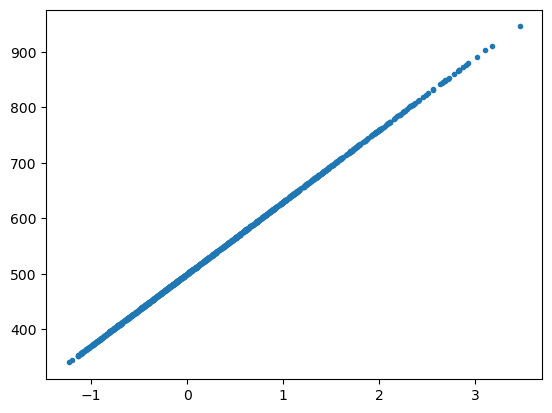

In [8]:
# e finalmente, vamos comparar o nosso cálculo a partir dos padrões de resposta 
# e os parâmetros IRT dado pelo INEP, com a nota do INEP dado nos microdados.
prova=1076 #MT 2022
#prova = 405 # MT 2017
padr,notas_inep= load_padr(prova,1000,nota_inep=True)
notas_atp = score_inep(padr,prova)

x = notas_atp['nota']
y = notas_inep['nota_inep']
#y = notas_inep['acertos']

plt.plot(x,y,'.');

In [9]:
res = scipy.stats.linregress(x, y)
display(res)
print(f"\nslope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")

LinregressResult(slope=129.6269388754438, intercept=500.02990711473865, rvalue=0.9999995661655728, pvalue=0.0, stderr=0.0038221448364954337, intercept_stderr=0.0038544647518978965)


slope = 129.6269388754438, intercept = 500.02990711473865, stderr = 0.0038221448364954337


Porém, veremos que nem sempre conseguimos reproduzir a nota do INEP perfeitamente. Há algum problema com alguns anos e áreas. Precisamos descobrir o que acontece.

In [73]:
df = pd.DataFrame(columns=['prova','slope','intercept','stderr'])
df['prova'] = df['prova'].astype('int')
df.loc[len(df)] = [1,2,3,4]
df.dtypes


prova        int64
slope        int64
intercept    int64
stderr       int64
dtype: object

In [77]:
provas(2009,'MT')

array([61, 64, 62, 63])

Ano 2009 e prova = 51: slope = 113.09349326664695, intercept = 501.1480033446574, stderr = 0.0013373742619896055
Ano 2009 e prova = 50: slope = 113.0874676401501, intercept = 501.1507872932597, stderr = 0.001658779294911267
Ano 2009 e prova = 49: slope = 113.09185068221072, intercept = 501.14820246784467, stderr = 0.001428046482709706
Ano 2009 e prova = 52: slope = 113.08759913008214, intercept = 501.1510960747114, stderr = 0.0014972244336225256
Ano 2010 e prova = 91: slope = 113.0899574809671, intercept = 501.1476465812865, stderr = 0.0015226866896737505
Ano 2010 e prova = 90: slope = 113.09155587600085, intercept = 501.146571326162, stderr = 0.0014750253064494988
Ano 2010 e prova = 92: slope = 113.09229513786963, intercept = 501.1471003909664, stderr = 0.0014614652282421993
Ano 2010 e prova = 89: slope = 113.09395182623865, intercept = 501.1471562187593, stderr = 0.0014965600454268661
Ano 2012 e prova = 143: slope = 113.08852056906068, intercept = 501.1486324314174, stderr = 0.001418

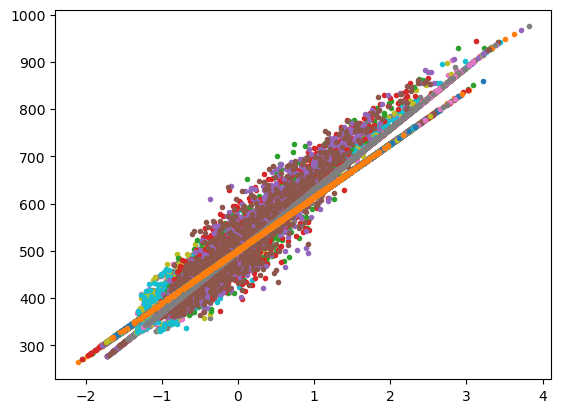

In [110]:
# vamos ter que pular o ano 2011 para a área CN, porque existe um item que não foi marcado como abandonado, 
# mas para qual o INEP não deu os parâmetros IRT
# TODO: investigar se o item foi abandonado (conseguimos reproduzir as notas do INEP sem este item) 
# OU se o item foi usado, mas não sabemos os parâmetros. 
# Estamos com dificuldades de reproduzir exatamente as notas de 2017 e 2018 também. TODO: investigar as razões
results = pd.DataFrame(columns=['ano','area','prova','slope','intercept','stderr'])
for area in ['CN','MT','CH']:
    for ano in range(2009,2023):
        if ano in [2011,2017,2018]: # veja acima 
            continue
        provs = provas(ano,area)
        for prova in provs:
            padr,notas_inep= load_padr(prova,1000,nota_inep=True)
            
            notas = score_inep(padr,prova)
            
            x = notas['nota']
            y = notas_inep['nota_inep']
            plt.plot(x,y,'.')
            res = scipy.stats.linregress(x, y)
            print(f"Ano {ano} e prova = {prova}: slope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")
            results.loc[len(results)] = [ano,area,prova,res.slope,res.intercept,res.stderr]
    
results['prova'] = results['prova'].astype('int')
results['ano'] = results['ano'].astype('int')    
results.to_csv(f'data/scorecal.csv',index=False)

In [108]:
results.set_index('prova').loc[53]['slope']

112.298750849987

In [6]:
scalecalparams(prova=51)

(113.09349326664696, 501.1480033446574)

## Respostas aleatórias
A primeira coisa para tentar é simular alunos que dão resp

In [4]:
area = 'CN'
provas(2022,area)

array([1088, 1085, 1087, 1086])

<AxesSubplot:ylabel='Frequency'>

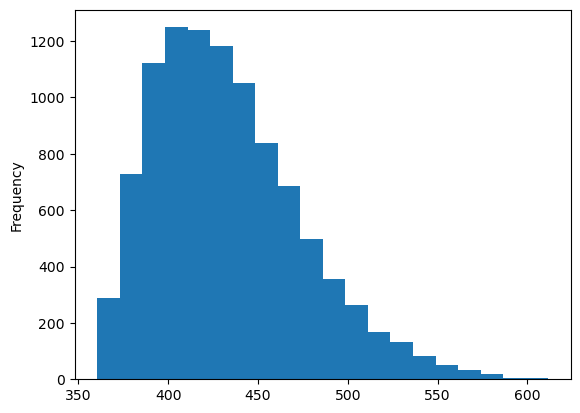

In [11]:
def padr_random(prova,p=0.2,N=1):
    itens = item_info_inep(prova=prova).query("IN_ITEM_ABAN == 0")['CO_ITEM']
    cols = itens.astype(int).sort_values().values
    padr = np.random.default_rng().random(size=(N,len(itens))) < p
    #padr = np.random.randint(0,2,size=(N,len(itens)))
    df = pd.DataFrame(padr,columns = cols)
    return df.astype(int)

prova = 1088
padr = padr_random(prova,0.2,10000)
scores = score_inep(padr,prova)
enem_scale(scores['nota'],'CN').plot(kind='hist',bins=20)

## Contrafactual: o candidato acerta ou erra uma questão a mais
O que acontece se por um acaso ou destração ou falta de tempo um candidato erra ou acerta um determinado item a mais ou a menos? Como isso influi na nota do ENEM. Talvez é interessante fazer esta análise para questões fáceis, de média dificuldade e difíceis? 

In [13]:
def flip_item(padr,item):
    padr2 = padr.copy()
    padr2[item] = 1 - padr[item] # flip the answers of one item
    return padr2

prova=1088 
padr1 = load_padr(prova,1000)
padr1

,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210057826464,1,1,0,1,0,1,0,1,0,0,...,0,1,0,0,1,0,1,1,1,0
210057945241,0,0,0,0,0,1,0,1,0,1,...,1,1,0,1,1,0,0,1,0,0
210055514287,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
210056949200,0,1,0,1,1,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
210054717243,1,0,1,0,1,0,0,0,1,1,...,1,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210056676287,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
210056640129,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,0,0,0
210057544147,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,1,0


In [14]:
padr2 = flip_item(padr1,28034)
padr3 = flip_item(padr2,18228)

In [ ]:
notas_atp1 = score_inep(padr1,prova)
notas_atp2 = score_inep(padr2,prova)
notas_atp3 = score_inep(padr3,prova)

<StemContainer object of 3 artists>

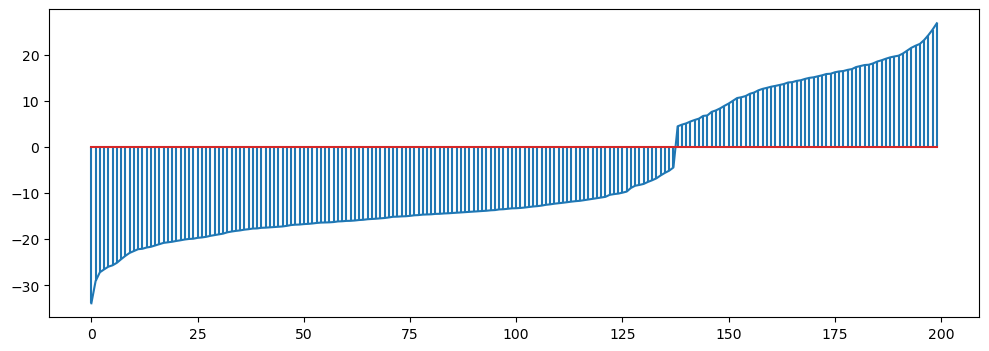

In [100]:
diff = (enem_scale(notas_atp1['nota'],'CN') - enem_scale(notas_atp2['nota'],'CN')).sort_values()
fig,ax = plt.subplots(figsize=(12,4))
ax.stem(diff[::5],linefmt='-',markerfmt='',use_line_collection=True)

<AxesSubplot:>

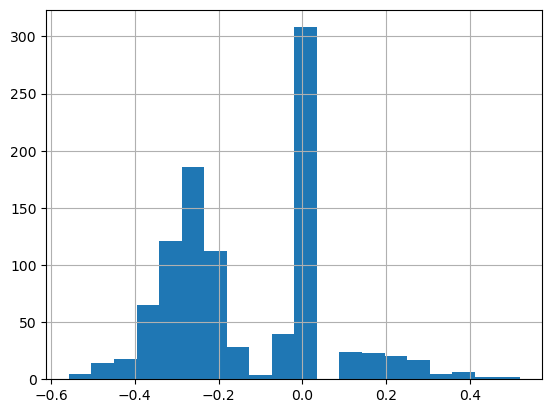

In [51]:
diff.hist(bins=20)

In [18]:
def change_fig(notas_orig,nota_nova):
    ''
    fig = plt.figure()
    diff = (notas_orig['nota'] - nota_nova['nota']).sort_values()
    
    return fig

change_fig(notas_atp1['nota,notas_atp3)


TypeError: sort_values() missing 1 required positional argument: 'by'

<Figure size 640x480 with 0 Axes>

## Contrafactual: eliminar uma questão

In [191]:
prova=1088 
padr1 = load_padr(prova,1000)
score_inep(padr1,prova)

,nota,se
candidato,,
210057361350,-0.160707,0.606349
210056492663,-0.949931,0.681869
210056299033,-0.858969,0.695143
210056592173,-0.302416,0.707352
210055518640,0.382073,0.414450
...,...,...
210055657463,-0.214069,0.514000
210056696038,0.322437,0.416567
210055866823,-0.711485,0.608909


In [241]:
params_inep(prova).sort_values('b_inep')

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
141503,2.86161,0.49480,0.16060,1
78716,2.02681,0.56741,0.24520,1
126560,2.41581,0.78824,0.19317,1
88655,3.82953,0.85524,0.11511,1
141712,1.87507,0.91052,0.15109,1
43073,1.48588,0.96735,0.24215,1
41054,1.20120,0.97602,0.22536,1
97727,2.35097,1.00991,0.30639,1
97761,0.89240,1.01697,0.29789,1


In [431]:
def dropitems(prova,items,N=1000):
    padr1,notas_inep = load_padr(prova,N,nota_inep=True)
    padr2 = padr1.drop(columns=items)
    param2 = params_inep(prova).drop(items)
    notas1 = score_inep(padr1,prova)
    notas2 = score_inep(padr2,params=param2)
    df = pd.concat([notas1,notas2],axis=1)
    df.columns=['nota','se1','nota2','se2']
    df['diff'] = df['nota'] - df['nota2']
    return pd.concat([df,padr1,notas_inep],axis=1)

prova = 448
di = 111612
#df = dropitems(prova,[141503,78716,126560])
df = dropitems(prova,[di])
#df = dropitems(prova,[83901,97915,141731])
#df = dropitems(prova,[141731])


/opt/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


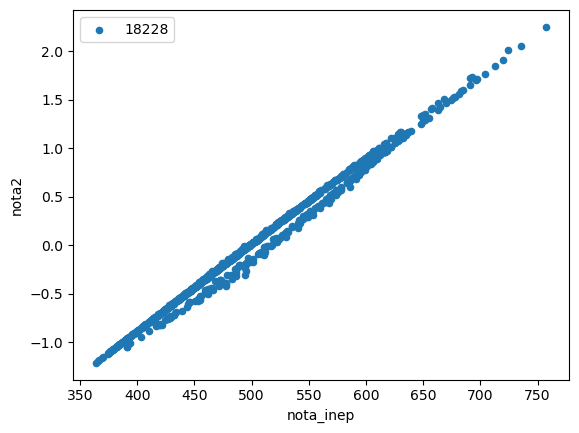

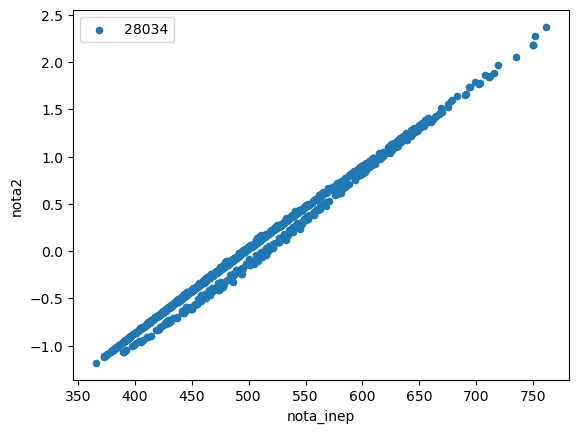

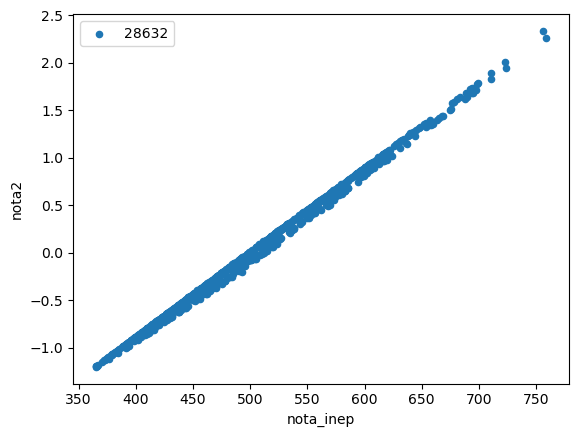

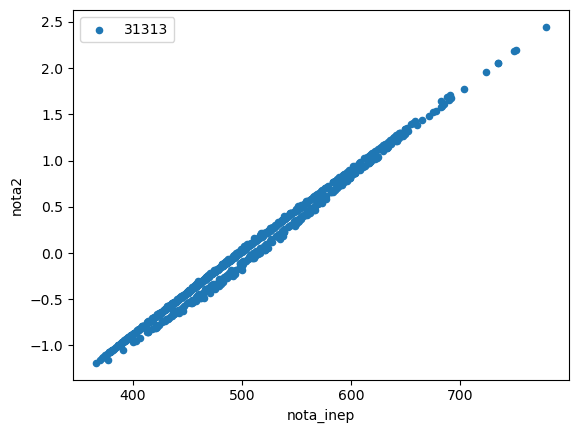

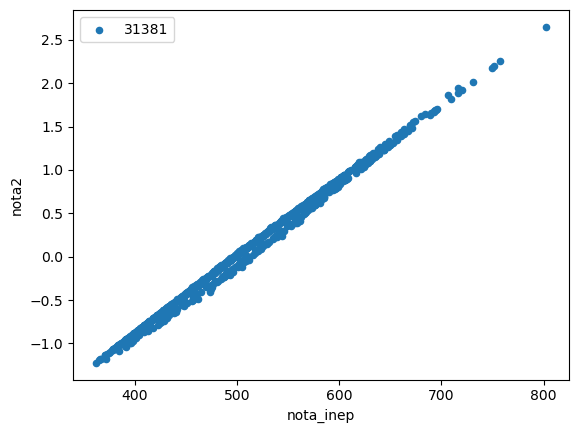

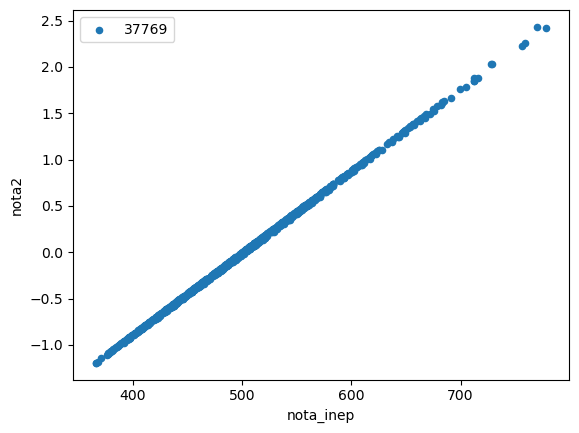

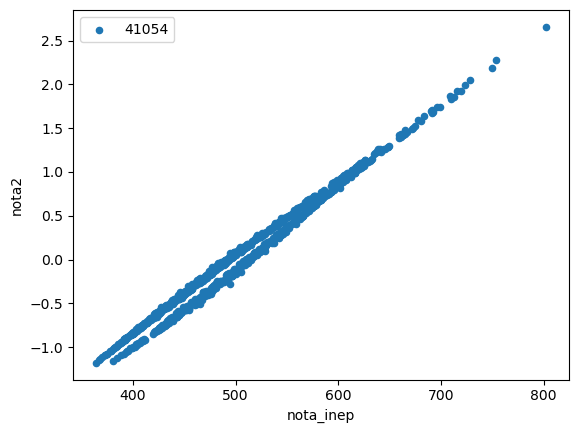

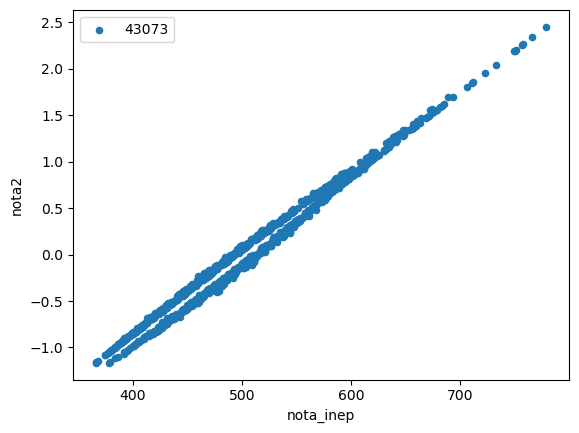

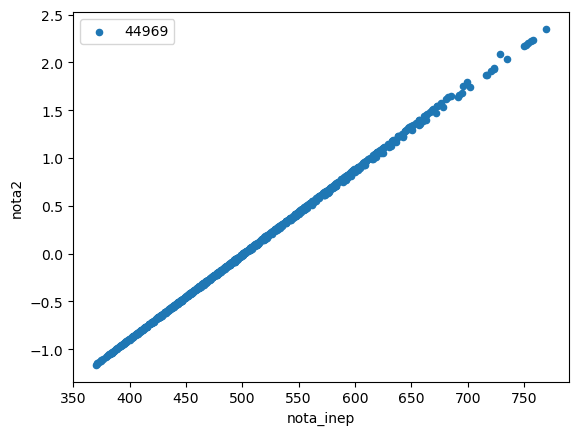

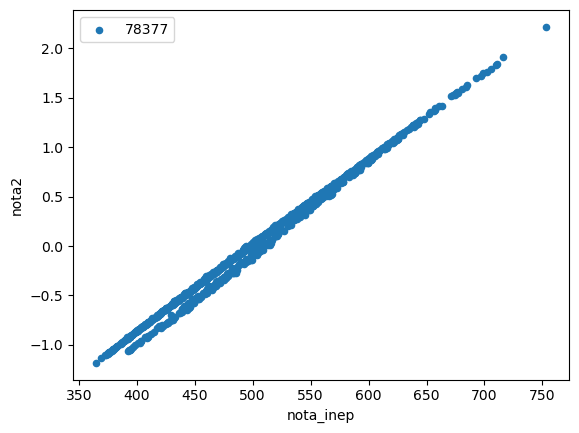

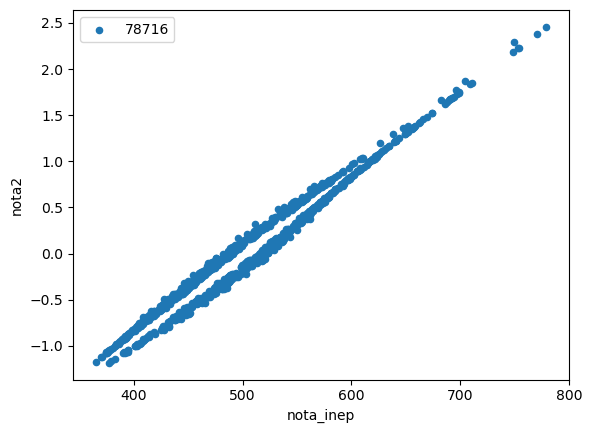

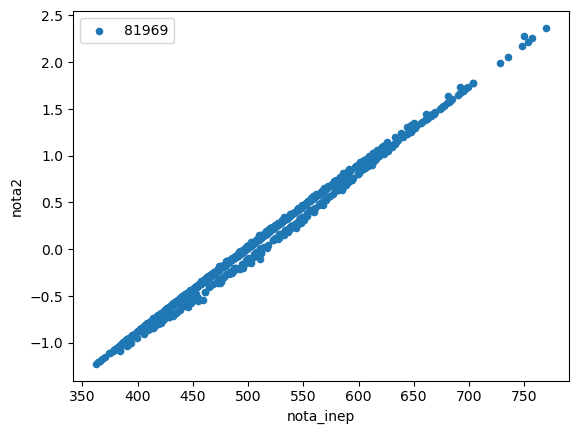

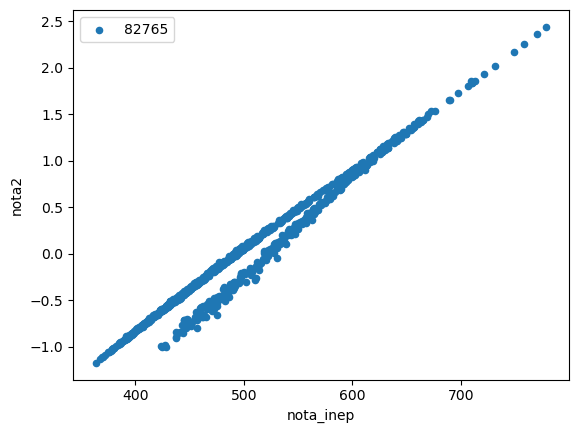

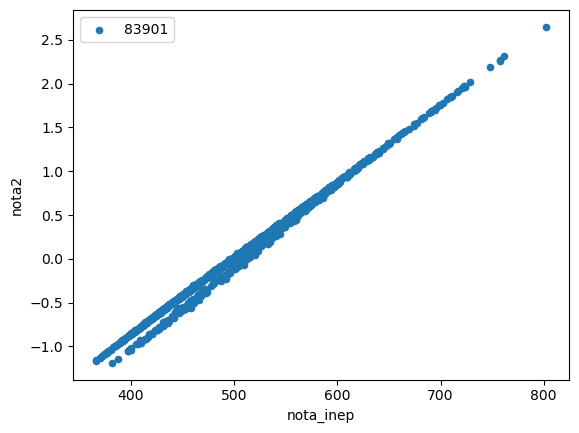

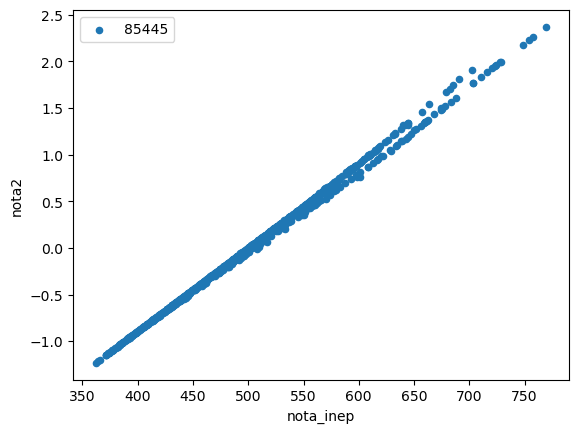

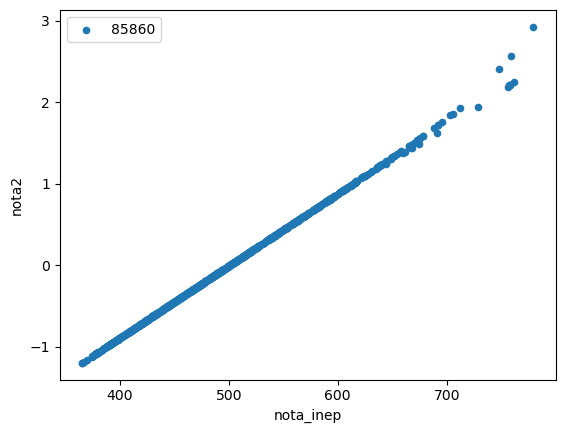

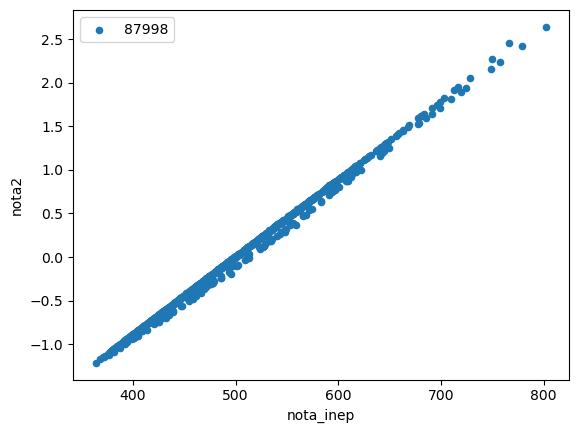

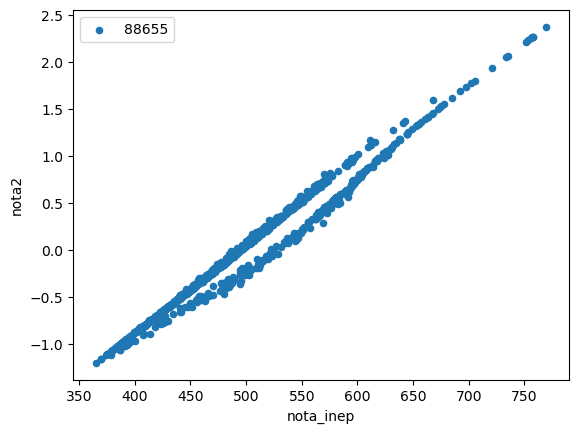

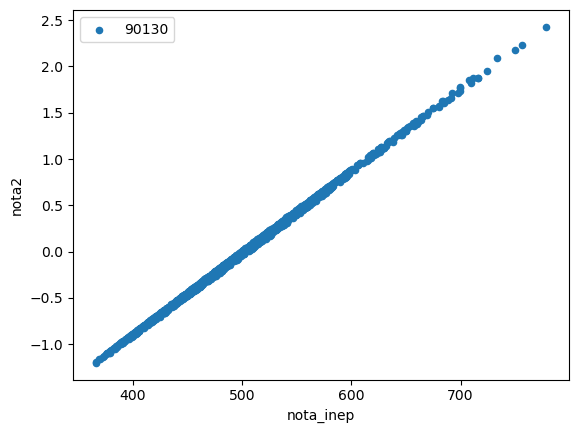

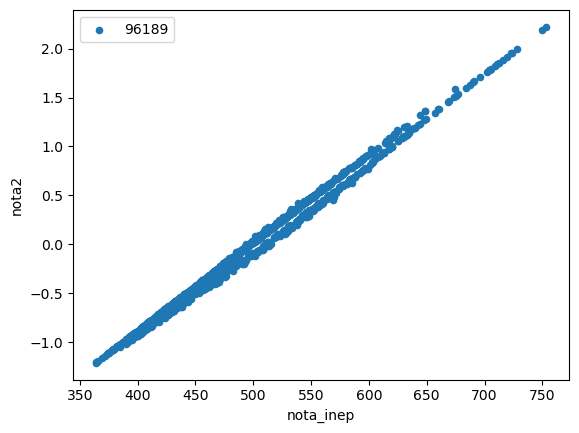

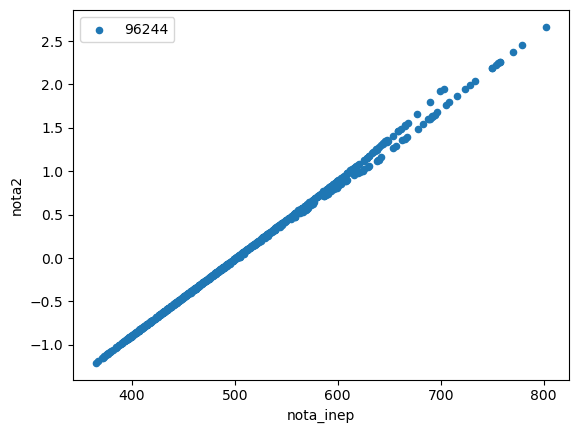

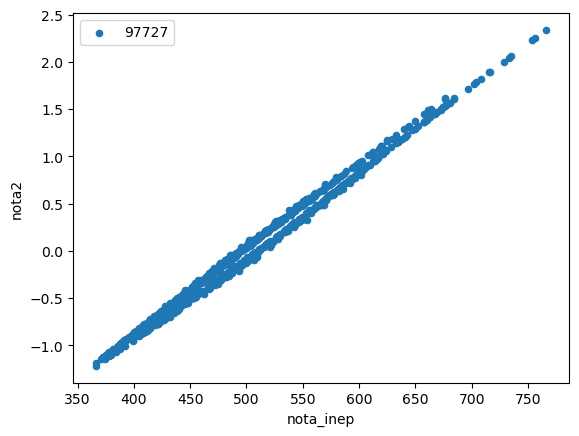

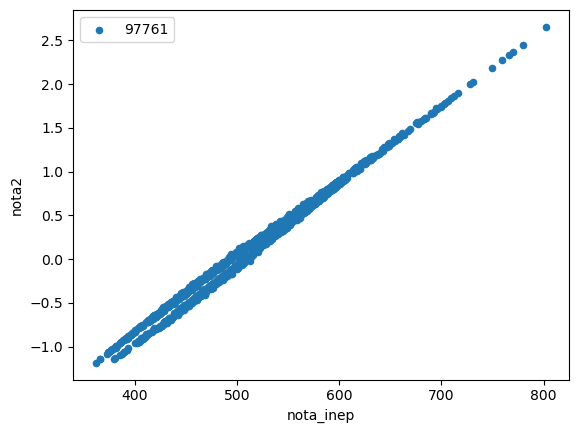

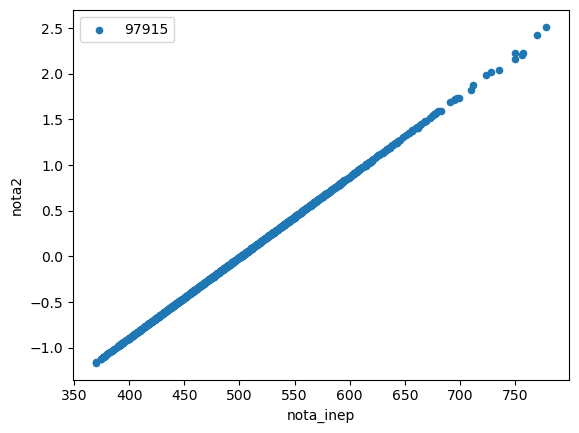

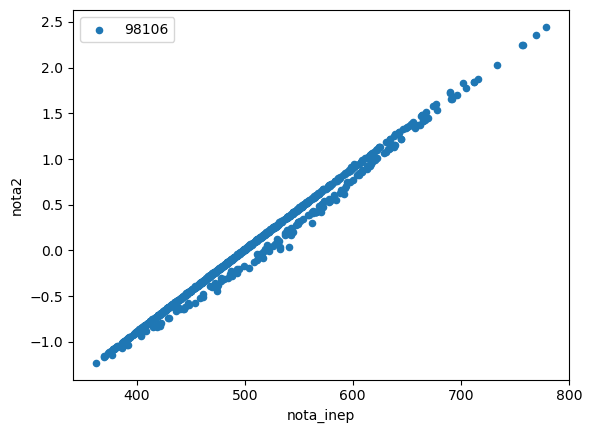

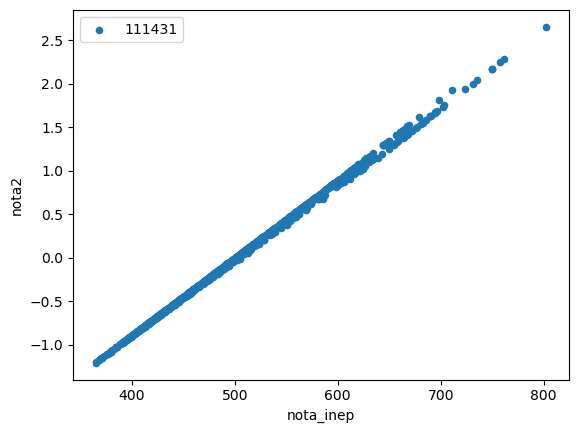

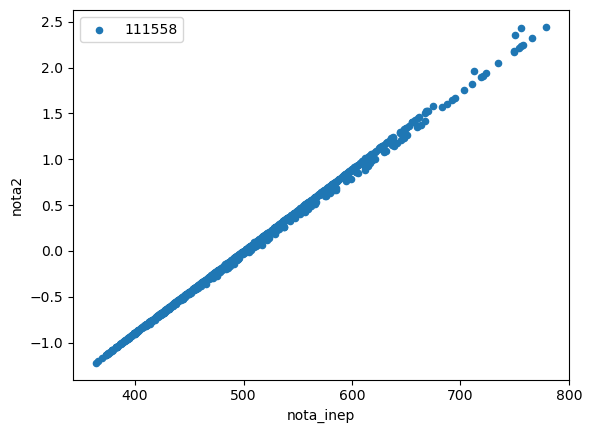

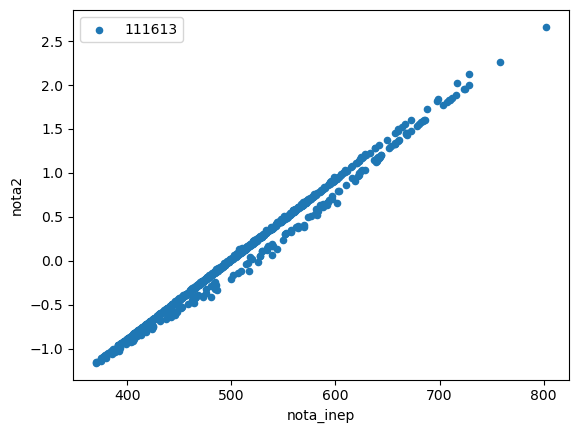

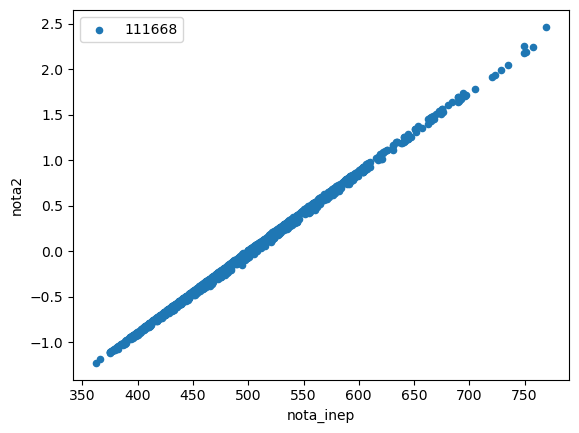

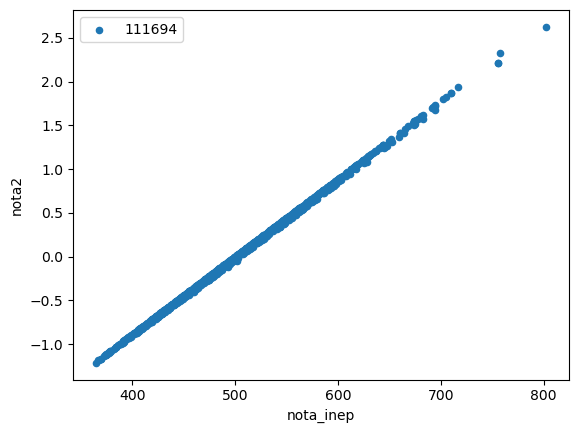

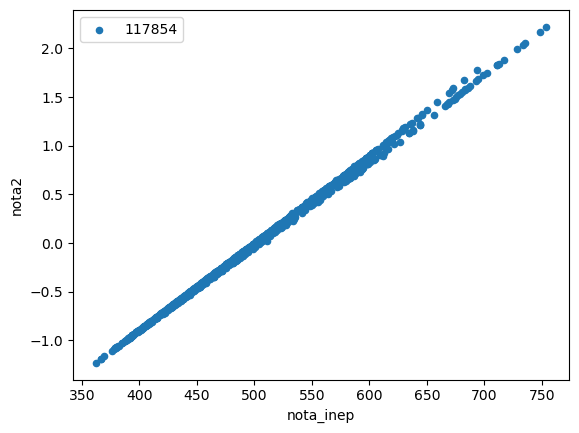

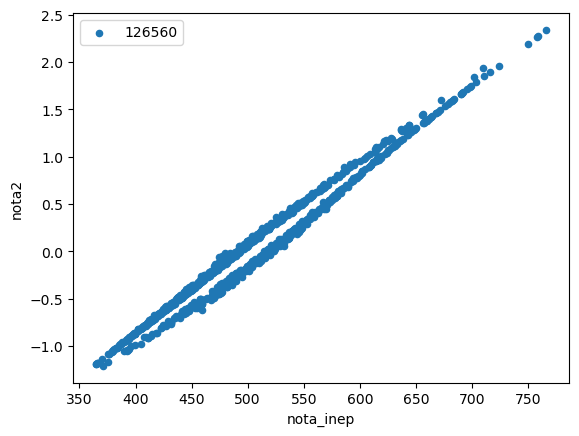

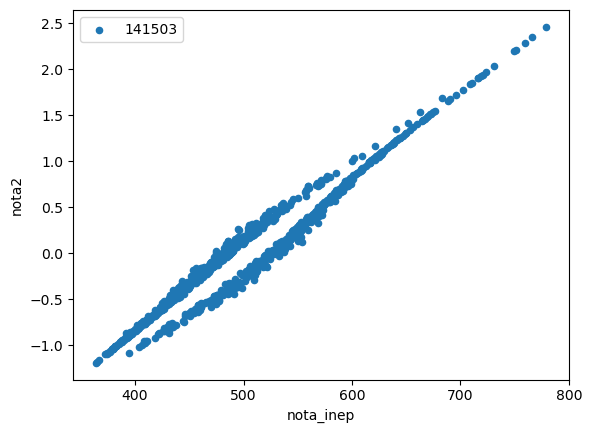

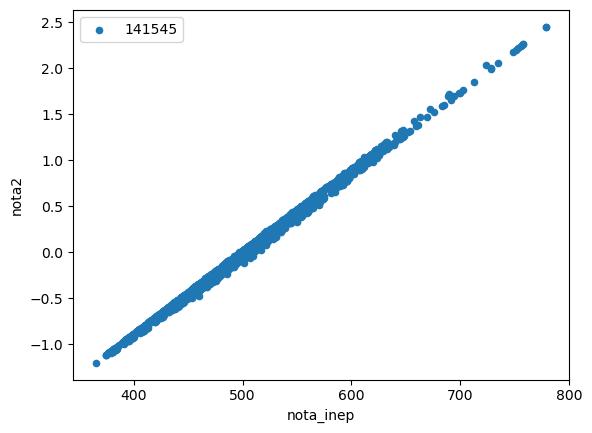

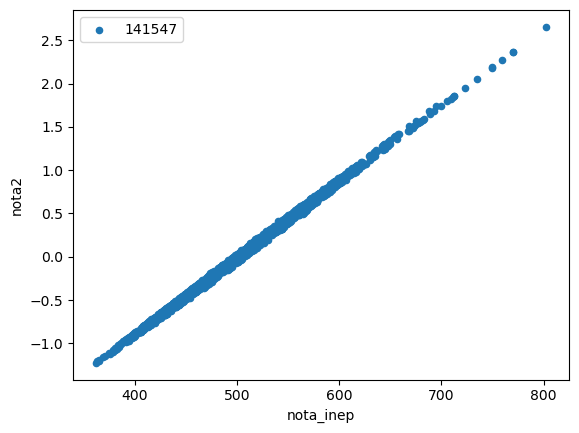

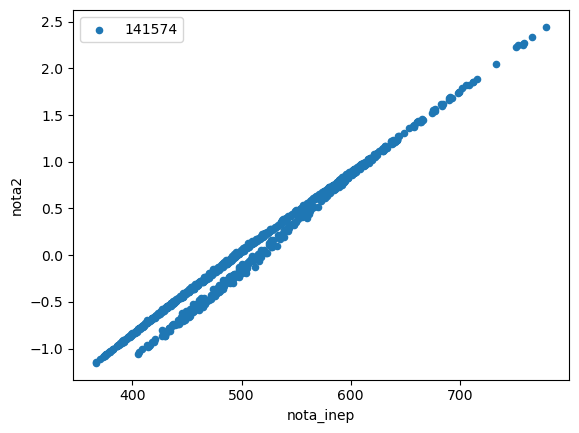

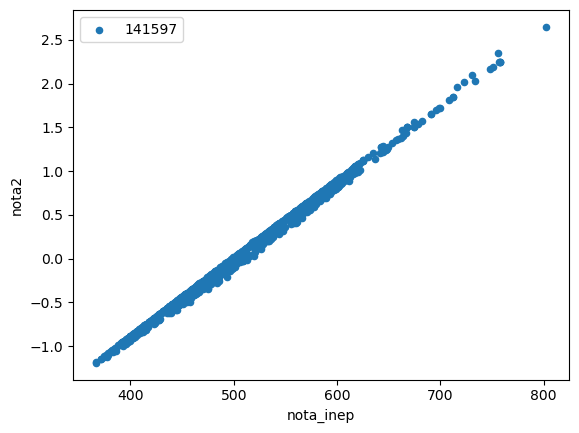

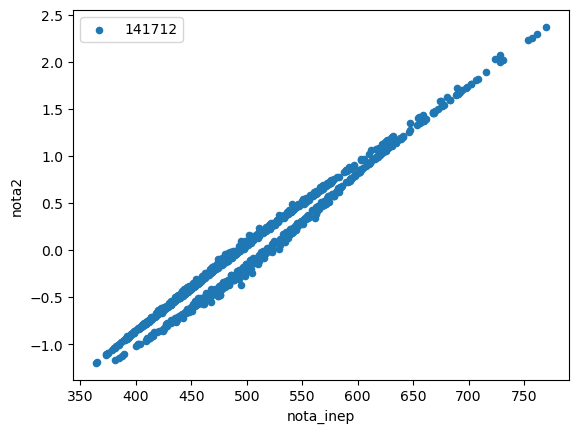

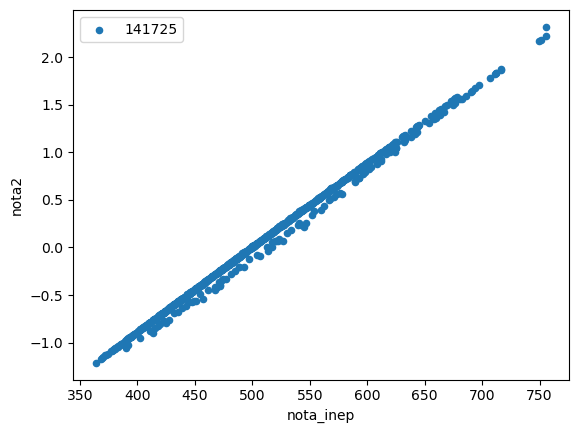

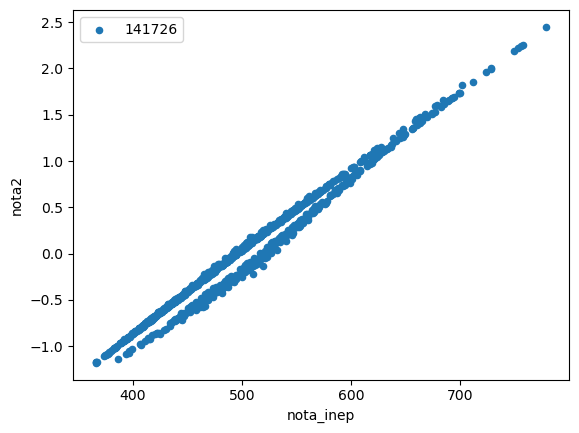

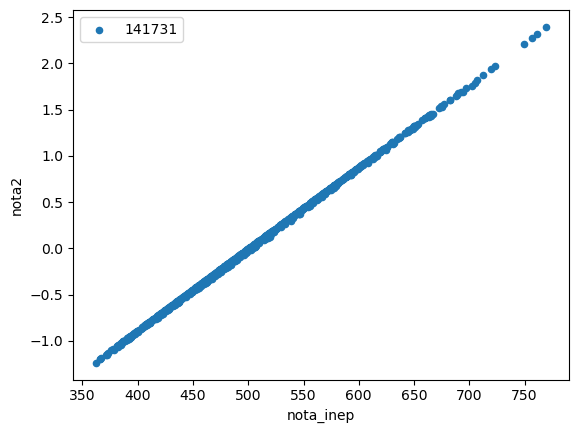

In [447]:
prova = 1088
for di in params_inep(prova).index:
    df = dropitems(prova,[di])
    #sns.scatterplot(df,x='nota2',y='nota_inep',hue=di)
    df.plot(x='nota_inep',y='nota2',kind='scatter',label=di)
#plt.plot([-1,2],[-1,2],'g-')

In [432]:
df.sort_values('nota')[:20]

,nota,se1,nota2,se2,diff,11526,12199,12591,17449,27417,...,111612,111630,111635,111637,111653,111720,111761,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
180012956898,-1.216367,0.636802,-1.214890,0.637768,-0.001477,0,0,0,1,0,...,0,0,0,0,0,0,0,3,448,363.9
180012691947,-1.193173,0.644673,-1.197937,0.641539,0.004765,0,0,0,1,1,...,1,0,0,0,0,0,1,6,448,367.0
180007198460,-1.184820,0.648765,-1.182638,0.650287,-0.002182,0,0,0,0,0,...,0,0,0,1,0,0,0,5,448,379.3
180013581776,-1.165577,0.656669,-1.162733,0.658749,-0.002845,0,0,1,0,0,...,0,0,0,1,0,0,1,5,448,368.6
180008892749,-1.145394,0.656465,-1.142627,0.658353,-0.002767,0,1,0,1,0,...,0,0,0,0,0,0,0,5,448,372.2
180010605177,-1.141687,0.664463,-1.138122,0.667086,-0.003565,0,0,0,1,1,...,0,0,0,0,0,0,1,7,448,372.7
180012731750,-1.131004,0.655583,-1.137574,0.651448,0.006570,0,0,0,0,0,...,1,0,1,0,0,0,0,4,448,374.0
180008162351,-1.112720,0.663321,-1.109273,0.665661,-0.003447,0,0,0,0,0,...,0,0,0,0,0,0,1,5,448,391.1
180010160771,-1.105367,0.642906,-1.103056,0.644287,-0.002311,1,0,0,0,0,...,0,0,0,0,0,0,0,2,448,376.6


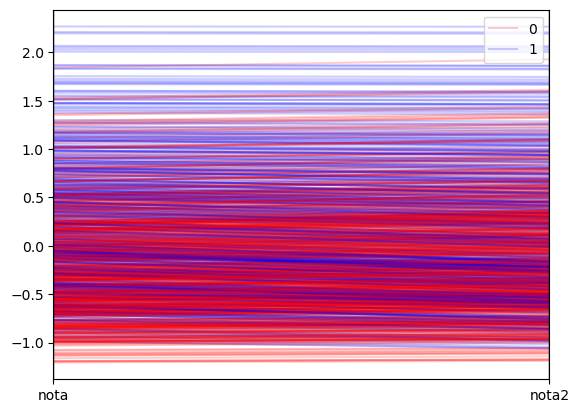

In [399]:
ax = pd.plotting.parallel_coordinates(df.sample(1000),126560,cols=['nota','nota2'],alpha=0.2,color=['red','blue'])
#ax.set_ylim(-2,2)
ax.grid(False)


In [316]:
df.sort_values('nota')

,nota,se1,nota2,se2,diff,141503,78716,126560
candidato,,,,,,,,
210055045291,-1.164673,0.677503,-1.048435,0.722278,-0.116237,0,0,0
210056484436,-1.147919,0.677830,-1.031547,0.719353,-0.116372,0,0,0
210055787734,-1.136846,0.683549,-1.009262,0.731160,-0.127585,0,0,0
210054531042,-1.118650,0.644999,-1.026083,0.670881,-0.092568,0,0,0
210055425372,-1.117910,0.676352,-1.002295,0.712385,-0.115615,0,0,0
...,...,...,...,...,...,...,...,...
210057586676,2.231141,0.218758,2.224688,0.219697,0.006453,1,1,1
210054877056,2.267678,0.229206,2.261146,0.230118,0.006532,1,1,1
210056983043,2.281028,0.220889,2.275254,0.221508,0.005774,1,1,1


In [317]:
df.corr(method='spearman')

,nota,se1,nota2,se2,diff,141503,78716,126560
nota,1.000000,-0.892126,0.908192,-0.801010,0.357767,0.565941,0.424664,0.403023
se1,-0.892126,1.000000,-0.851276,0.929580,-0.239782,-0.452927,-0.356106,-0.317661
nota2,0.908192,-0.851276,1.000000,-0.852714,-0.035531,0.323145,0.214079,0.241611
se2,-0.801010,0.929580,-0.852714,1.000000,-0.016582,-0.310973,-0.209576,-0.227886
diff,0.357767,-0.239782,-0.035531,-0.016582,1.000000,0.680426,0.541873,0.426046
141503,0.565941,-0.452927,0.323145,-0.310973,0.680426,1.000000,0.173156,0.140570
78716,0.424664,-0.356106,0.214079,-0.209576,0.541873,0.173156,1.000000,0.146366
126560,0.403023,-0.317661,0.241611,-0.227886,0.426046,0.140570,0.146366,1.000000


In [237]:
prova = 1088
itens = params_inep(prova).sort_values('b_inep')
easy = itens.index[:21]
dif = itens.index[21:]
notas1,notas2 = dropitems(prova,easy)

print(notas1.se.mean(),notas2.se.mean())
(notas1['nota'] - notas2['nota']).describe()

0.5287207951082803 0.7730641510431417


count    1000.000000
mean        0.043521
std         0.533225
min        -1.784428
25%        -0.319069
50%         0.048172
75%         0.413905
max         1.575356
Name: nota, dtype: float64

## Contrafactual: mudanças nos parâmetros IRT
O INEP calibrou os parâmetros a,b e c dos itens que usaram. Como a nota ENEM mudaria se estes parâmetros variam (um pouco)? Afinal, a própria determinação dos parâmetros introduz uma incerteza nestes parâmetros. Como esta incerteza se propaga na nota ENEM?

In [154]:
# Esta função usa o arquivo data/itens_inep.csv para extrair os parâmetros dos itens dado pelo INEP
prova = 1088
params = params_inep(prova)
params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
18228,1.95358,1.46498,0.11246,1
28034,1.51222,1.41874,0.14908,1
28632,1.99451,1.78678,0.12762,1
31313,1.71131,1.42364,0.16150,1
31381,1.75013,1.52509,0.16155,1
37769,1.78429,2.50062,0.27071,1
41054,1.20120,0.97602,0.22536,1
43073,1.48588,0.96735,0.24215,1
44969,3.07166,1.89127,0.25272,1


In [157]:
prova = 1088
params = params_inep(prova)
params2 = params_inep(prova)
# mudar o parâmetro b aleatoriamente aprox. 10%
params2['b_inep'] = params2['b_inep']*(1+0.1*np.random.normal(size=len(params)))
params2 - params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
18228,0.0,0.127548,0.0,0
28034,0.0,-0.178814,0.0,0
28632,0.0,-0.108116,0.0,0
31313,0.0,-0.206782,0.0,0
31381,0.0,-0.100310,0.0,0
37769,0.0,0.107367,0.0,0
41054,0.0,-0.102751,0.0,0
43073,0.0,-0.015892,0.0,0
44969,0.0,-0.019262,0.0,0


In [158]:
prova = 1088
params1 = params_inep(prova)
params2 = params_inep(prova)
# mudar o parâmetro b aleatoriamente aprox. 10%
params2['b_inep'] = params2['b_inep']*(1+0.1*np.random.normal(size=len(params1)))
padr, notas_inep = load_padr(prova,1000,nota_inep=True)
# podemos usara params na função score_
notas1 = score_inep(padr,params=params1)
notas2 = score_inep(padr,params=params2)
diff = (notas1 - notas2)['nota']
display(diff)
diff.describe()

candidato
210054693207    0.120308
210054901440    0.022190
210057861952    0.059222
210054751439   -0.058812
210055416605   -0.012550
                  ...   
210055934407   -0.015831
210056127285    0.003778
210054824787    0.031664
210057392629    0.127491
210056068289    0.052574
Name: nota, Length: 1000, dtype: float64

count    1000.000000
mean        0.007699
std         0.041982
min        -0.147904
25%        -0.018659
50%         0.006813
75%         0.031372
max         0.168879
Name: nota, dtype: float64

## Contrafactual: usar outro método do EAP 
Vamos ver o efeito de usar MAP ou ML

In [159]:
prova=1088 # CN, 2022
slope, intercept = 113.091, 501.150

padr,notas_inep= load_padr(prova,1000,nota_inep=True)
notas_atp = score_inep(padr,prova)

notas_inep['nota_inep'] - (notas_atp['nota']*slope + intercept)

candidato
210056438707    0.061344
210057498773    0.053649
210057431826   -0.046572
210057527267   -0.010198
210056902588   -0.028022
                  ...   
210055864778    0.044714
210057450370   -0.008710
210057269453    0.027112
210055331687   -0.032637
210057410415    0.043629
Length: 1000, dtype: float64

In [160]:
n1 = score_inep(padr,prova)
n2 = score_inep(padr,prova,method='MAP')
n1['nota'] - n2['nota']

candidato
210056438707   -0.167191
210057498773   -0.269798
210057431826   -0.125728
210057527267   -0.219281
210056902588   -0.193430
                  ...   
210055864778   -0.301221
210057450370   -0.262109
210057269453   -0.224314
210055331687   -0.339988
210057410415   -0.152702
Name: nota, Length: 1000, dtype: float64

In [60]:
(n1['nota'] - n2['nota']).describe()

count    1000.000000
mean       -0.219736
std         0.109718
min        -0.626621
25%        -0.287963
50%        -0.221241
75%        -0.155742
max         0.047604
Name: nota, dtype: float64

In [62]:
n1 = score_inep(padr,prova)
n2 = score_inep(padr,prova,method='ML')
(n1['nota'] - n2['nota'])

candidato
210057603415   -0.257938
210056997508    0.181118
210057377114   -0.319535
210057092200         inf
210056455088   -0.292013
                  ...   
210055123313   -0.092120
210057501893   -0.157405
210056326271   -0.095986
210055975622   -0.224849
210054987615   -0.172722
Name: nota, Length: 1000, dtype: float64

In [69]:
(n1['nota'] - n2['nota']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    876.000000
mean      -0.141648
std        0.347117
min       -0.699673
25%       -0.283582
50%       -0.199166
75%       -0.104971
max        2.431584
Name: nota, dtype: float64

## Contrafactual: usar soma dos acertos ao vez de IRT
A mudança mais radical no cálculo da nota seria não usar IRT e sim a soma dos acertos dos itens. Sabemos que existem bons argumentos para usar IRT e que isso não é uma decisão arbitrária, mas mesmo assim vale a pena visual como, *em princípio*, a nota do candidato poderia ter sido bastante diferente.

Vamos usar uma função load_acertos em util.py que além dos padrões de respostas tras mais três colunas: o número de acertos, o código da prova e a nota que o INEP calculou.

In [6]:
load_acertos(2022,'CN',3)

,117854,141545,78377,97761,78716,96189,141712,43073,141574,18228,...,28632,126560,97727,28034,97915,141503,88655,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210055540729,1,0,1,0,1,1,0,0,1,0,...,0,0,0,0,1,1,0,14,1086,497.3
210055689725,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,5,1086,422.8
210057963005,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,6,1085,410.1


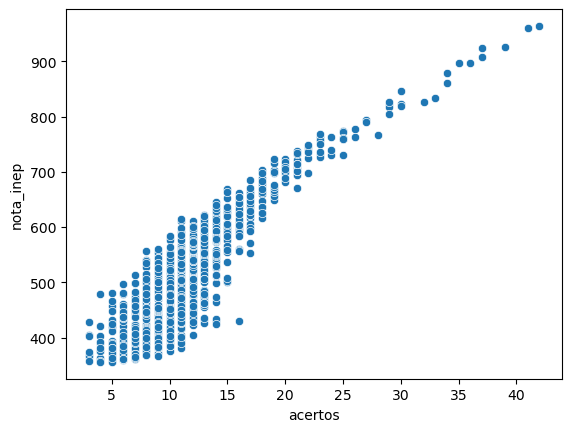

In [178]:
data = load_acertos(2017,'MT',1000)
sns.scatterplot(data,x='acertos',y='nota_inep');

In [10]:
data.query('acertos == 10')['nota_inep'].describe()

count     95.000000
mean     459.762105
std       31.438377
min      393.200000
25%      435.300000
50%      459.900000
75%      479.000000
max      524.500000
Name: nota_inep, dtype: float64

Vemos que candidatos com por exemplo 10 acertos são atribuidos notas ENEM que variam de 393 até 524.